In [22]:
import scipy.io.wavfile as wavfile
import matplotlib.pyplot as plt
import numpy as np
from scipy import signal, fft
import matplotlib.pyplot as plt


In [23]:
fs, audio = wavfile.read('ENF-WHU-Dataset_H1_001.wav')
# fs, audio = wavfile.read('/content/sample_data/001.wav')
N = len(audio)
print(N)

3861649


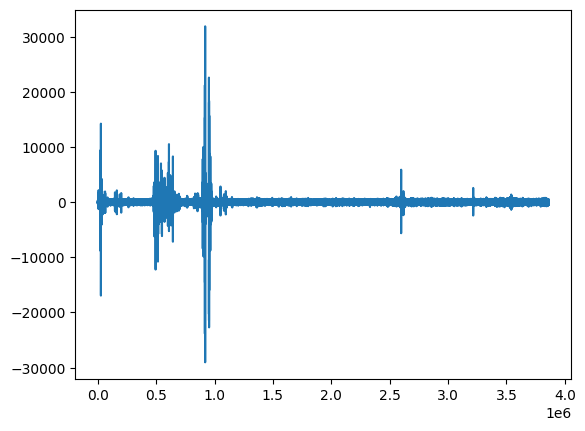

In [24]:
plt.figure(figsize=(6.4, 4.8))
plt.plot(audio)

(95.0, 105.0)

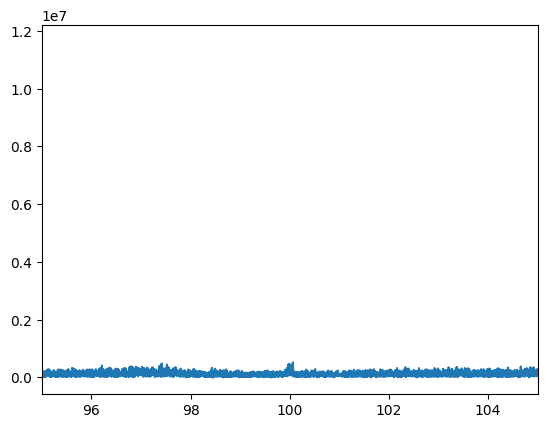

In [25]:
from scipy.fft import fft

sigfft = fft(audio, n=N)
abssigfft = np.abs(sigfft)
freqs = np.fft.fftfreq(N, 1 / fs)
plt.plot(freqs[:N//2], abssigfft[:N//2])
plt.xlim(95, 105)

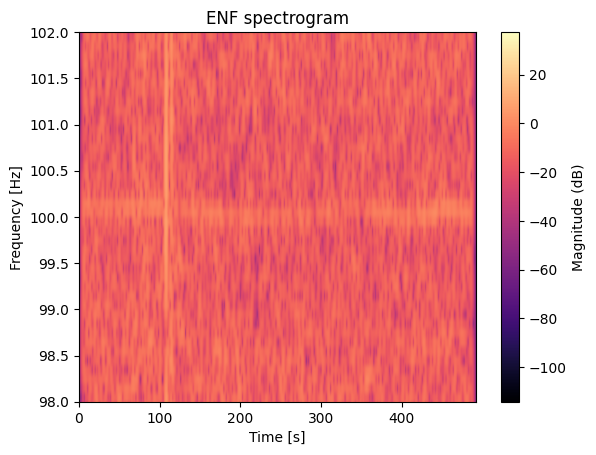

In [26]:
from scipy.signal import ShortTimeFFT, windows

w_s = fs * 10
std = w_s // 6
w = windows.gaussian(w_s, std=std)
hop = fs // 2

SFT = ShortTimeFFT(win=w, hop=hop, fs=fs, scale_to='magnitude')
Sx = SFT.spectrogram(audio)
Sx_dB = 10 * np.log10(Sx)
# Sx_dB = 10 * np.log10(np.maximum(Sx, 1e-12))

freqs = np.arange(Sx.shape[0]) * fs / w_s
times = np.arange(Sx.shape[1]) * hop / fs
# times = (np.arange(Sx.shape[1]) * hop + w_s/2) / fs

plt.imshow(
    Sx_dB,
    origin='lower',
    aspect='auto',
    extent=[times[0], times[-1], freqs[0], freqs[-1]],
    cmap='magma'
)

plt.colorbar(label='Magnitude (dB)')
plt.xlabel('Time [s]')
plt.ylabel('Frequency [Hz]')
plt.ylim(98, 102)
plt.title('ENF spectrogram')
plt.show()

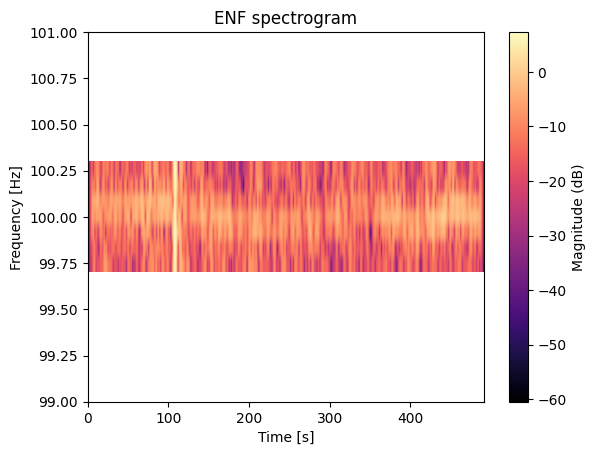

In [27]:
band_mask = (99.7 <= freqs) & (freqs <= 100.3)
Sx_dB_filtered = Sx_dB[band_mask, :]
filtered_freqs = freqs[band_mask]

plt.figure(figsize=(6.4, 4.8))
plt.imshow(
    Sx_dB_filtered,
    origin='lower',
    aspect='auto',
    extent=[times[0], times[-1], filtered_freqs[0], filtered_freqs[-1]],
    cmap='magma'
)

plt.colorbar(label='Magnitude (dB)')
plt.xlabel('Time [s]')
plt.ylabel('Frequency [Hz]')
plt.ylim(99, 101)
plt.title('ENF spectrogram')
plt.show()

In [28]:
fig = plt.figure(frameon=False)
ax = fig.add_axes([0, 0, 1, 1])

plt.imshow(
    Sx_dB_filtered,
    origin='lower',
    aspect='auto',
    cmap='magma',
    interpolation='bilinear'
)

ax.axis('off')
fig.canvas.draw()
width, height = fig.canvas.get_width_height() # (640, 480)
img = np.asarray(fig.canvas.buffer_rgba())
plt.close(fig)

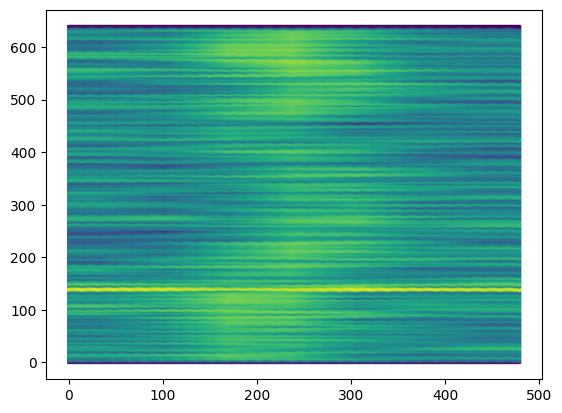

In [29]:
nx, ny, _ = img.shape
xx, yy = np.indices((nx, ny))
cords = np.column_stack((xx.ravel(), yy.ravel()))

def color_convert(c):
  r, g, b, _ = c
  lumi = int(0.2126*r + 0.7152*g + 0.0722*b)
  return lumi

img_flat = img.reshape(-1, 4)
colors = [color_convert(tuple(row)) for row in img_flat]

X = np.column_stack((cords, colors))
plt.figure(figsize=(6.4, 4.8))
plt.scatter(X[:, 0], X[:, 1], c=X[:, 2], s=2)
plt.show()

141.34073893229166 246


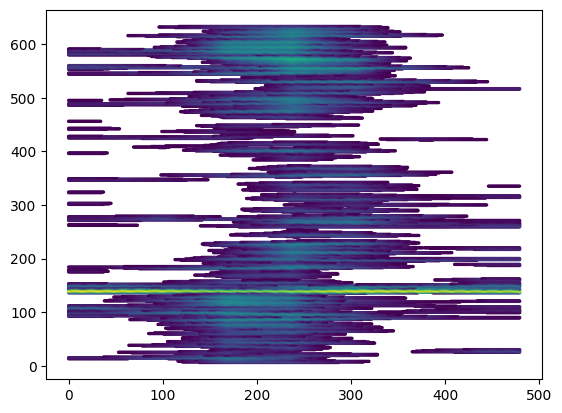

In [30]:
mean_color = X[:, 2].mean()
max_color = X[:, 2].max()
print(mean_color, max_color)

X_fileterd = X.copy()
X_fileterd = X_fileterd[X_fileterd[:, 2] > mean_color * 1.1, :]

plt.figure(figsize=(6.4, 4.8))
plt.scatter(X_fileterd[:, 0], X_fileterd[:, 1], c=X_fileterd[:, 2], s=2)
plt.show()

In [31]:
from sklearn.cluster import DBSCAN

def remove_outliers(data):
  min_y = min(data[:, 1])
  max_y = max(data[:, 1])
  sums = 0
  for y in range(min_y, max_y+1):
    line_mask = data[:, 1] == y
    if np.sum(line_mask) > 0:
      q1, q3 = np.percentile(data[line_mask, 0], [25, 75])
      lower_bound = q1
      upper_bound = q3
      # iqr = q3 - q1
      # lower_bound = q1 - 1.5 * iqr
      # upper_bound = q3 + 1.5 * iqr
      outliers_mask = line_mask & ((data[:, 0] < lower_bound) | (data[:, 0] > upper_bound))
      sums += np.sum(outliers_mask)
      data[outliers_mask, 2] = 500

  print(f'Removed: {sums}')
  return data[data[:, 2] != 500]

X_cleaned = remove_outliers(X_fileterd.copy())

Removed: 50666


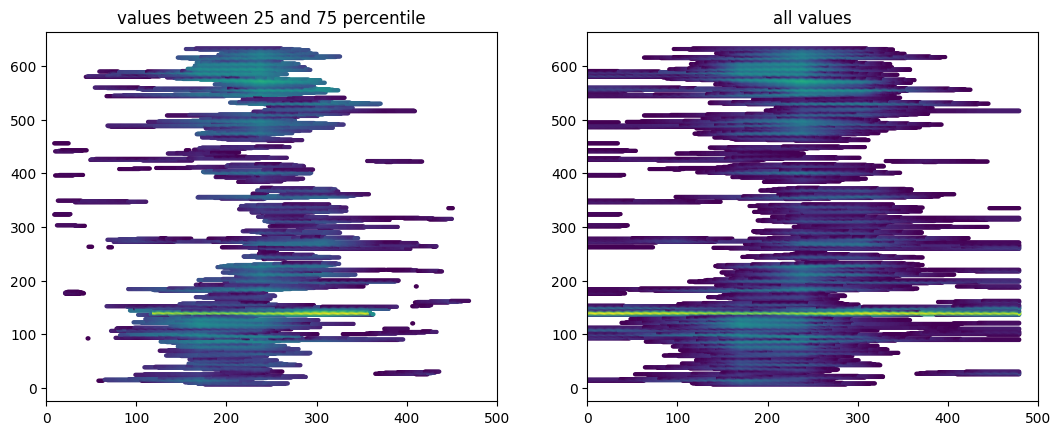

In [32]:
fig, ax = plt.subplots(1, 2, figsize=(6.4 * 2, 4.8))
ax[0].scatter(X_cleaned[:, 0], X_cleaned[:, 1], c=X_cleaned[:, 2], s=4)
ax[0].set_xlim(0, 500)
ax[0].set_title('values between 25 and 75 percentile')
ax[1].scatter(X_fileterd[:, 0], X_fileterd[:, 1], c=X_fileterd[:, 2], s=4)
ax[1].set_xlim(0, 500)
ax[1].set_title('all values')
plt.show()

In [33]:
X_scaled = np.column_stack((X_cleaned[:, [0, 1]], X_cleaned[:, 2] / 100))

In [34]:
# fig, ax = plt.subplots(55, 1, figsize=(8, 55*8))
# i = 0
# for eps in range(5, 10):
#   for min_samples in range(35, 80, 5):
#     metric = 'euclidean'
#     model = DBSCAN(eps = eps, min_samples = min_samples, metric = metric)
#     model.fit(X_scaled)

#     ax[i].scatter(X_scaled[:, 0], X_scaled[:, 1], c=model.labels_)
#     ax[i].set_title(f'eps: {eps}, {min_samples}')
#     i += 1
# plt.tight_layout()
# plt.show()

In [35]:
metric = 'euclidean'
model = DBSCAN(eps = 8, min_samples = 60, metric = metric)
model.fit(X_scaled)

label_mask = model.labels_ != -1

X_grouped = X_scaled[label_mask]
labels = model.labels_[label_mask]

Text(0.5, 1.0, 'all values')

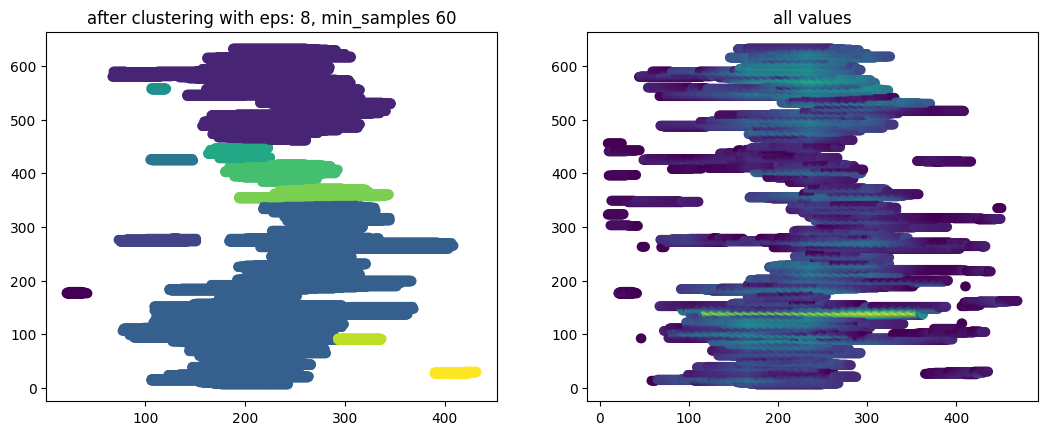

In [36]:
fig, ax = plt.subplots(1, 2, figsize=(6.4 * 2, 4.8))
ax[0].scatter(X_grouped[:, 0], X_grouped[:, 1], c=labels)
ax[0].set_title(f'after clustering with eps: {8}, min_samples {60}')
ax[1].scatter(X_cleaned[:, 0], X_cleaned[:, 1], c=X_cleaned[:, 2])
ax[1].set_title('all values')

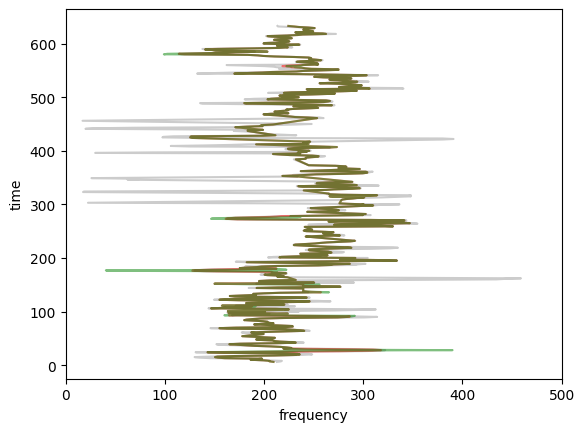

In [37]:
time_f, indices_f = np.unique(X_fileterd[:, 1], return_inverse = True)
time_g, indices_g = np.unique(X_grouped[:, 1], return_inverse = True)

means_f = np.bincount(indices_f, weights=X_fileterd[:, 0]) / np.bincount(indices_f)
means_g = np.bincount(indices_g, weights=X_grouped[:, 0]) / np.bincount(indices_g)

medians_f = np.array([
    np.median(X_fileterd[indices_f == i, 0])
    for i in range(len(time_f))
])

medians_g = np.array([
    np.median(X_grouped[indices_g == i, 0])
    for i in range(len(time_g))
])

enf_f = np.column_stack((time_f, means_f))
enf_g = np.column_stack((time_g, means_g))

plt.figure(figsize=(6.4, 4.8))
plt.plot(enf_f[:, 1], enf_f[:, 0], c='black', alpha=0.2)
plt.plot(enf_g[:, 1], enf_g[:, 0], c='red', alpha=0.5)

enf_f = np.column_stack((time_f, medians_f))
enf_g = np.column_stack((time_g, medians_g))

plt.plot(enf_g[:, 1], enf_g[:, 0], c='green', alpha=0.5)
plt.xlim(0, 500)
plt.ylabel('time')
plt.xlabel('frequency')
plt.show()